In [ ]:
# Generate Data

In [5]:
from numpy.random import normal
from matplotlib import pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import normalize
import seaborn as sns
import numpy as np
import pandas as pd

n_ = 100

#2 variables
#doubles gaussiennes toutes les deux


X, y = make_classification(n_samples=n_, 
                           n_features=3, 
                           n_informative=3, 
                           n_redundant=0, 
                           n_repeated=0, 
                           n_classes=2, 
                           n_clusters_per_class=1, 
                           weights=None, 
                           flip_y=0.1,
                           class_sep=1.0,
                           hypercube=True,
                           shift=0.0,
                           scale=1.0,
                           shuffle=True,
                           random_state=None)
#scale -1; 1
X = (X - X.mean(axis=0))/list(map(max, zip(abs(X.max(axis=0)), abs(X.min(axis=0)))))





'''#3D plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], zdir='z', s=20, depthshade=True, 
               color=[['blue', 'green',][int(i)] for i in y])
plt.show()'''

"#3D plot\nfrom mpl_toolkits.mplot3d import Axes3D\nfig = plt.figure()\nax = fig.gca(projection='3d')\nax.scatter(X[:, 0], X[:, 1], X[:, 2], zdir='z', s=20, depthshade=True, \n               color=[['blue', 'green',][int(i)] for i in y])\nplt.show()"

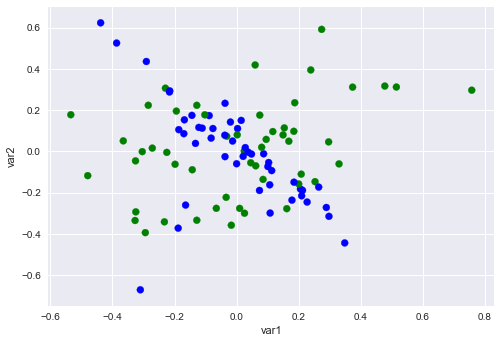

In [6]:
#2D plot
plt.scatter(X[:, 0], X[:, 1], color=[['blue', 'green'][int(i)] for i in y])
#plt.scatter(X[idx,0], X[idx, 1], color='red')
plt.xlabel('var1')
plt.ylabel('var2')
plt.show()

# Train a Classifier

In [7]:
'''
This script tests implementation of a usage of LIME https://github.com/marcotcr/lime
'''
from __future__ import print_function
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import lime
import lime.lime_tabular
import random


X_train, X_test, y_train, y_test = train_test_split(X, y)

clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('accuracy ', sum(y_pred == y_test)/len(y_test))

clf.feature_importances_

accuracy  0.88


array([ 0.2204399 ,  0.3325851 ,  0.44697501])

# LIME

In [10]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_test, feature_names=['var' + str(i) for i in range(X.shape[1])],#, 'var3'],
                                                   #class_names=list(map(str, iris.target_names)),
                                                   discretize_continuous=False,
                                                   verbose=True)
exp = explainer.explain_instance(X_test[idx], clf.predict_proba, num_features=5, top_labels=1)
print('score du fit du local au global', exp.score)


exp.show_in_notebook(show_table=True, show_all=False)

Intercept 0.585366003716
Prediction_local [ 0.63023561]
Right: 0.8
score du fit du local au global 0.616153235382


# Distance Matrix

In [8]:
from sklearn.metrics import pairwise_distances

D = pairwise_distances(X_test, metric='euclidean') 

### Picking the closest neighbors

In [9]:
idx = np.random.randint(X_test.shape[0])
neighbors_s = sorted(zip(range(D.shape[0]), D[idx, :], y_pred), key=lambda x: x[1])

def knn(neighbors, k=10, class_=None):
    if class_ == None:
        return neighbors[1:k+1]
    else:
        c_ = [x for x in neighbors if x[2]==class_]
        return c_[:k]


### Generating new observations between the observation and its neighbors

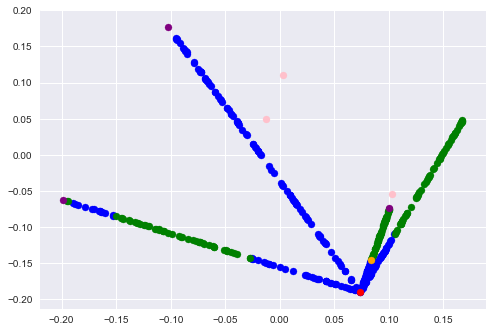

In order to cross the border, this observation would need:
0.010279 in variable 0 (-0.479732, 0.514409)
0.044149 in variable 1 (-0.394119, 0.316482)
0.139710 in variable 2 (-0.674189, 0.538708)


In [10]:
### 
import random

N = 4
AX1, AX2 = 0, 1

enn_ = [X_test[x[0]] for x in knn(neighbors_s, N, (1-y_pred[idx]))]
all_ = [X_test[x[0]] for x in knn(neighbors_s, N, (y_pred[idx]))[1:]]

#enn_ = enn_ + [X_test[idx] + [0.0 , 4.0, 0.0], X_test[idx] + [0.0 , -4.0, 0.0]]

d0 = 10000000000
for neigh in enn_:
    for i in range(100):
        alpha = random.random()
        new = alpha * X_test[idx] + (1 - alpha) * neigh
        pred_ = clf.predict(new.reshape(1, -1))[0]
        d_ = (sum((new - X_test[idx])**2))**(0.5)
        if (pred_ != y_pred[idx]) and d_ < d0:
            d0 = d_
            border = new
        c_ = ['blue', 'green'][pred_]
        plt.scatter(new[AX1], new[AX2], color=c_)

plt.scatter(X_test[idx, AX1], X_test[idx, AX2], color='red')
plt.scatter(enn_[0][AX1], enn_[0][AX2], color='purple')
plt.scatter(enn_[1][AX1], enn_[1][AX2], color='purple')
plt.scatter(enn_[2][AX1], enn_[2][AX2], color='purple')
plt.scatter(all_[0][AX1], all_[0][AX2], color='pink')
plt.scatter(all_[1][AX1], all_[1][AX2], color='pink')
plt.scatter(all_[2][AX1], all_[2][AX2], color='pink')
plt.scatter(border[AX1], border[AX2], color='orange')


plt.show()


#print(X[idx], nn_[0],  border)


print('In order to cross the border, this observation would need:')
for v in range(X_test.shape[1]):
    print('%f in variable %d (%f, %f)' %(border[v] - X_test[idx, v], v, X_test[:, v].min(), X_test[:, v].max()))


0 0 0
1 0.0001 0
2 0.0002 0
3 0.00030000000000000003 0
4 0.0004 0
5 0.0005 0
6 0.0006000000000000001 0
7 0.0007000000000000001 1


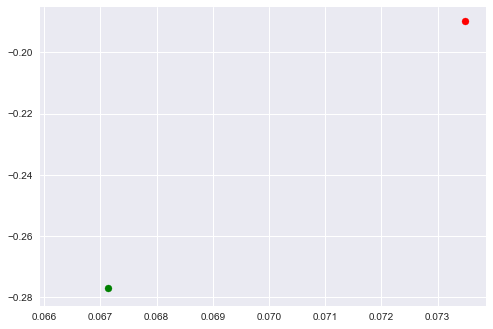

In order to join its neighbour, our observation would need:
-0.006343 in variable 0 (value= 0.073487); Range= (-0.479732, 0.514409)
-0.087418 in variable 1 (value= -0.189636); Range= (-0.394119, 0.316482)
0.017966 in variable 2 (value= -0.164190); Range= (-0.674189, 0.538708)


C:\Users\Thibault\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\Thibault\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [40]:
### faire grandir une boule
#import random
from numpy import random
from math import pi, cos, sin
#from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import manhattan_distances


d = X_test.shape[1]
obs_pred = int(clf.predict(X_test[idx].reshape(1, -1)))

def norm(v):
    return sum(map(lambda x: x**2, v))**(0.5)

def generate_inside_ball(center, d, segment=(0,1)):
    z = random.normal(0, 1, d)
    z = z/norm(z) * random.uniform(*segment)**(1/float(d))
    z += center
    return z


def generate_inside_manhattan(center, d, segment=(0,1)):
    return 0

def generate_layer_with_pred(center, d, n, segment, prediction=1):
    out = []
    for i in range(n):
        a = generate_inside_ball(center, d, segment=segment)
        pred = clf.predict(a.reshape(1, -1))
        a = list(a)
        a.append(pred)
        out.append(a)
    return np.array(out)


###GENERE SPHERES A LA SUITE DE PLUS EN PLUS GRANDES; S ARRETE QUAND A TROUVE LE NOMBRE VOULU D ENNEMIS
N_LAYER = 100
STEP=1/10000.0
ENOUGH_ENNEMIES = 1
count_ennemies = 0
ennemies = []
a0 = 0
i = 0
a1 = STEP
while count_ennemies < ENOUGH_ENNEMIES:
    layer_ = generate_layer_with_pred(X_test[idx], d, n=100, segment=(a0, a1))
    count_ennemies += int(abs(int(sum(layer_[:, -1])) - N_LAYER*obs_pred))
    ennemies.extend([x for x in layer_ if x[-1] == 1-obs_pred])
    plt.scatter([x[0] for x in ennemies], [x[1] for x in ennemies], color=[['blue', 'green'][int(x[-1])] for x in ennemies])
    print(i, a0, count_ennemies)
    i += 1
    a0 += STEP
    a1 += STEP


plt.scatter(X_test[idx, 0], X_test[idx, 1], color='red')
plt.show()    
ennemies = sorted(ennemies, key=lambda x: manhattan_distances(x[:-1], X_test[idx]))

for border in ennemies:
    print('In order to join its neighbour, our observation would need:')
    for v in range(X_test.shape[1]):
        print('%f in variable %d (value= %f); Range= (%f, %f)' %(border[v] - X_test[idx, v], v, X_test[idx,v], X_test[:, v].min(), X_test[:, v].max()))



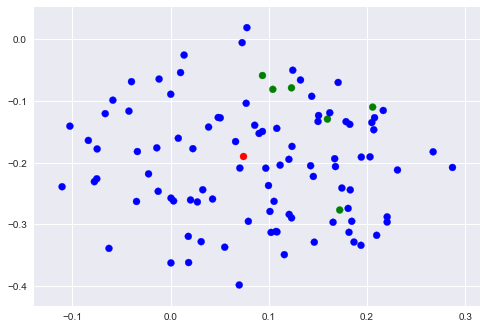

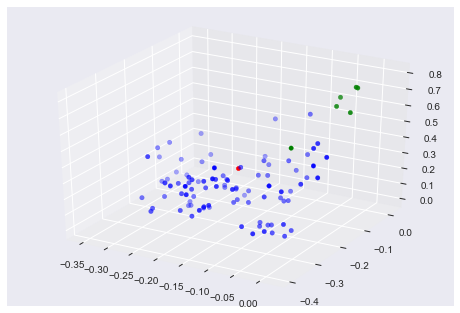

[0.29999999999999999,
 0.10000000000000001,
 0.0,
 0.29999999999999999,
 0.10000000000000001,
 0.20000000000000001,
 0.29999999999999999,
 0.10000000000000001,
 0.20000000000000001,
 0.20000000000000001,
 0.69999999999999996,
 0.0,
 0.5,
 0.29999999999999999,
 0.29999999999999999,
 0.29999999999999999,
 0.10000000000000001,
 0.20000000000000001,
 0.5,
 0.20000000000000001,
 0.0,
 0.40000000000000002,
 0.40000000000000002,
 0.10000000000000001,
 0.10000000000000001,
 0.29999999999999999,
 0.0,
 0.20000000000000001,
 0.0,
 0.0,
 0.10000000000000001,
 0.20000000000000001,
 0.20000000000000001,
 0.29999999999999999,
 0.40000000000000002,
 0.10000000000000001,
 0.20000000000000001,
 0.10000000000000001,
 0.5,
 0.29999999999999999,
 0.20000000000000001,
 0.0,
 0.5,
 0.10000000000000001,
 0.5,
 0.20000000000000001,
 0.10000000000000001,
 0.10000000000000001,
 0.40000000000000002,
 0.69999999999999996,
 0.29999999999999999,
 0.10000000000000001,
 0.29999999999999999,
 0.5,
 0.29999999999999999

In [24]:
###REGARDER PROBAS DANS L ESPACE

N_LAYER = 1000
STEP=1/100.0
d = X_test.shape[1]
layer_ = generate_layer_with_pred(X_test[idx], d, n=100, segment=(0, STEP))
plt.scatter([x[0] for x in layer_], [x[1] for x in layer_], color=[['blue', 'green'][int(x[-1])] for x in layer_])
plt.scatter(X_test[idx, 0], X_test[idx, 1], color='red')
plt.show()    


probs_ = [clf.predict_proba(x[:-1].reshape(1, -1))[0][1] for x in layer_]
probs_

#3D plot
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter([x[2] for x in layer_], [x[1] for x in layer_], [x for x in probs_], zdir='z', s=20, depthshade=True, 
               color=[['blue', 'green',][int(i>0.5)] for i in probs_])
ax.scatter(X_test[idx,2], X_test[idx, 1], clf.predict_proba(X_test[idx].reshape(1, -1))[0][1], color='red')
plt.show()




In [38]:
from sklearn.metrics import pairwise_distances_argmin_min

#dist_to_idx = pairwise_distances(X_test[idx].reshape(1, -1), layer_[:,:-1])

#calculer tous les gradients de la surface




(1, 100)

In [19]:
obs_pred = int(clf.predict(X_test[idx].reshape(1, -1)))
obs_pred

1

### Test lien proba distance

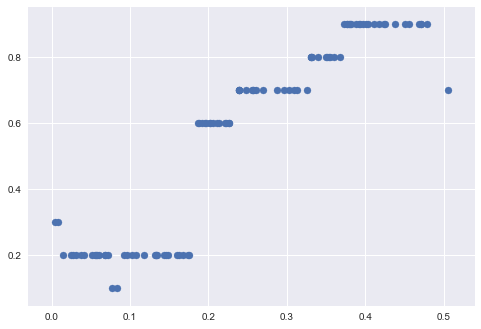

In [39]:
### 
import random

N = 1

enn_ = [X_test[x[0]] for x in knn(neighbors_s, N, (1-y_pred[idx]))]
all_ = [X_test[x[0]] for x in knn(neighbors_s, N, (y_pred[idx]))[1:]]

#enn_ = enn_ + [X_test[idx] + [0.0 , 4.0, 0.0], X_test[idx] + [0.0 , -4.0, 0.0]]

d0 = 10000000000
dist, probas = [], []
for neigh in enn_:
    for i in range(100):
        alpha = random.random()
        new = alpha * X_test[idx] + (1 - alpha) * neigh
        pred_prob = clf.predict_proba(new.reshape(1, -1))[0]
        #d_ = (sum((new - X_test[idx])**2))**(0.5)
        d_ = manhattan_distances(X_test[idx].reshape(1,-1), new.reshape(1,-1))
        dist.append(d_)
        probas.append(pred_prob[1])
plt.scatter(dist, probas)
plt.show()



### Test marche aléatoire

In [123]:
AX1, AX2 = 0, 1

start, prob_start = X_test[idx], clf.predict_proba(X_test[idx].reshape(1, -1))[0][1]
goal= int(prob_start<0.5)
print(start, prob_start, goal)
i = 0
pred = int(prob_start>=0.5)

def progress(prob1, prob2):
    if prob1>= 0.5:
        return prob2<=prob1
    else:
        return prob2>=0.5

def color(obs):
    return ['blue', 'green'][clf.predict(obs.reshape(1, -1))[0]]

while pred != goal:
    i += 1
    alpha = random.uniform(-3, 3)
    direction = random.randint(0, 2)
    new = np.array(start + [alpha if i==direction else 0 for i in range(X_test.shape[1])])
    prob_new = clf.predict_proba(new.reshape(1,-1))[0][1]
    if progress(prob_start, prob_new):
        print(i, prob_start, prob_new, new)
        plt.scatter(new[AX1], new[AX2], color='orange')
        plt.plot([start[AX1], new[AX1]], [start[AX2], new[AX2]], color='purple')
        start = new
        prob_start = prob_new
        pred = int(prob_new>=0.5)
        
        import pdb;pdb.set_trace()

plt.scatter(X_test[idx][AX1], X_test[idx][AX2], color=color(X_test[idx]))
plt.scatter(new[AX1], new[AX2], color=color(new))


plt.show()
print('In order to cross the border, this observation would need:')
for v in range(X_test.shape[1]):
    print('%f in variable %d (%f, %f)' %(new[v] - X_test[idx, v], v, X_test[:, v].min(), X_test[:, v].max()))

[ 0.25121615 -3.15044507  1.0724528  -0.26857383  1.00589309  0.89634076
 -1.15344429  0.146743   -1.29201537  2.79036038] 1.0 0
1 1.0 1.0 [-1.56750452 -3.15044507  1.0724528  -0.26857383  1.00589309  0.89634076
 -1.15344429  0.146743   -1.29201537  2.79036038]
> <ipython-input-123-8e2427f97306>(18)<module>()
-> while pred != goal:
(Pdb) c
2 1.0 1.0 [-1.56750452 -0.33745148  1.0724528  -0.26857383  1.00589309  0.89634076
 -1.15344429  0.146743   -1.29201537  2.79036038]
> <ipython-input-123-8e2427f97306>(18)<module>()
-> while pred != goal:
(Pdb) c
3 1.0 1.0 [-1.56750452 -2.32630571  1.0724528  -0.26857383  1.00589309  0.89634076
 -1.15344429  0.146743   -1.29201537  2.79036038]
> <ipython-input-123-8e2427f97306>(18)<module>()
-> while pred != goal:
(Pdb) c
4 1.0 1.0 [-1.56750452 -2.32630571  1.00704129 -0.26857383  1.00589309  0.89634076
 -1.15344429  0.146743   -1.29201537  2.79036038]
> <ipython-input-123-8e2427f97306>(18)<module>()
-> while pred != goal:
(Pdb) c
5 1.0 1.0 [-1.56750

BdbQuit: 

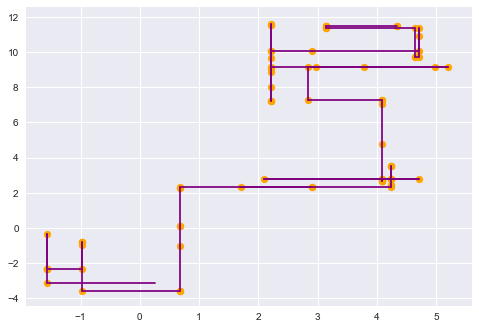

In [124]:
plt.show()

In [122]:
idx = np.random.randint(X_test.shape[0])